In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim 
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from tqdm import tqdm
import time 

c:\Users\Aneesh\anaconda3\envs\vision_models\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
#Creating a new model class that is essentially just the ViT model minus the classification head. This will get us our features.
class ViTEmbeddingNet(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, x):
        outputs = self.vit(x)
        # Use [CLS] token (first token in the sequence) as embedding
        return outputs.last_hidden_state[:, 0]

In [4]:
data = pd.read_csv("camera_data/coronado_hills_binary_10-18-25.csv")
data = data.get(["choice", "image"]).fillna(0)

data["choice"] = data["choice"].apply(lambda x: 0 if x == 0 else 1)
data.head()

,choice,image
0,1,https://tools.alertcalifornia.org/fireframes5/...
1,0,https://tools.alertcalifornia.org/fireframes5/...
2,0,https://tools.alertcalifornia.org/fireframes5/...
3,0,https://tools.alertcalifornia.org/fireframes5/...
4,0,https://tools.alertcalifornia.org/fireframes5/...


In [5]:
import urllib.request
import os

if len(os.listdir("camera_data/images")) == 0:
    for i in range(3890, len(data)):
        img_path = f"camera_data/images/img_{i}.jpg"
        urllib.request.urlretrieve(data.iloc[i]['image'], img_path)

In [6]:
img_names = [f"camera_data/images/img_{i}.jpg" for i in range(len(data))]

data["img_path"] = img_names

In [7]:
#Defining a dataset class to import the images. We resize them to 224 by 224 since that's what the model expects, but make no other transformations.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts PIL to Tensor
])

class CustomImageDataset(Dataset):
    def __init__(self, data_df, transform = None):
        self.data = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 2]
        label = int(self.data.iloc[idx, 0])
    
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
#Creating the dataset and loading it into batches with the DataLoader class
dataset = CustomImageDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)

In [9]:
#Instatiating encoder and loading it to chosen device
encoder = ViTEmbeddingNet(vit)

encoder.to(device) 

ViTEmbeddingNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_f

In [10]:
#Defining optimizer, loss function, and what kind of mining to use for triplets
optimizer = optim.Adam(encoder.parameters(), lr=1e-5)  # Smaller LR for pretrained models
loss_func = TripletMarginLoss(margin=0.18)
miner = TripletMarginMiner(margin=0.18, type_of_triplets="semihard")

In [11]:
#This is where we would train the model (it's commented out because it takes about ~1.5 hours to run each time), just loading the weights here instead


start = time.time()
i = 0
for images, labels in tqdm(dataloader):

    images = images.to(device)
    labels = labels.to(device)

    embeddings = encoder(images)

    # Use miner to find triplets from labels + embeddings
    mined_triplets = miner(embeddings, labels)

    # Pass embeddings, labels, and mined triplets
    loss = loss_func(embeddings, labels, mined_triplets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%10 == 0:
        mid = time.time()
        print(f"Time at iteration {i}: {(mid - start)/60:.2f} minutes")
        print(f"Loss: {loss.item()}")
    i += 1


#encoder.load_state_dict(torch.load('model_weights.pth', weights_only=True))
#encoder.eval()

  1%|▏         | 1/67 [00:05<05:42,  5.19s/it]

Time at iteration 0: 0.09 minutes
Loss: 0.10541870445013046


 16%|█▋        | 11/67 [00:56<04:43,  5.07s/it]

Time at iteration 10: 0.93 minutes
Loss: 0.09654197841882706


 31%|███▏      | 21/67 [01:49<04:16,  5.58s/it]

Time at iteration 20: 1.82 minutes
Loss: 0.09239859879016876


 45%|████▍     | 30/67 [02:40<03:29,  5.67s/it]

Time at iteration 30: 2.76 minutes


 46%|████▋     | 31/67 [02:46<03:26,  5.72s/it]

Loss: 0.09797517955303192


 60%|█████▉    | 40/67 [03:34<02:28,  5.51s/it]

Time at iteration 40: 3.67 minutes


 61%|██████    | 41/67 [03:40<02:26,  5.64s/it]

Loss: 0.09863054752349854


 76%|███████▌  | 51/67 [04:41<01:37,  6.07s/it]

Time at iteration 50: 4.69 minutes
Loss: 0.08528298884630203


 91%|█████████ | 61/67 [05:38<00:35,  5.86s/it]

Time at iteration 60: 5.63 minutes
Loss: 0.08535441756248474


100%|██████████| 67/67 [06:07<00:00,  5.49s/it]


In [12]:
torch.save(encoder.state_dict(), 'model_weights_camera_10-18-25.pth')

In [13]:
#Get embeddings of the first batch of data
images, labels = next(iter(dataloader))

images = images.to(device)

embedding = encoder(images)

In [14]:
#Use PCA to reduce data to two dimensions so that we can visualize them 
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)

reduced_embedding = pca_model.fit_transform(embedding.to("cpu").detach().numpy())

In [15]:
labels_np = labels.detach().numpy()

In [16]:
#Checking to see how many images there are from each class
import numpy as np

count = {}

for i in range(6):
    count[i] = reduced_embedding[np.argwhere(labels_np == i)].shape[0]

count

{0: 41, 1: 23, 2: 0, 3: 0, 4: 0, 5: 0}

Number of green points: 41
Number of red points: 23


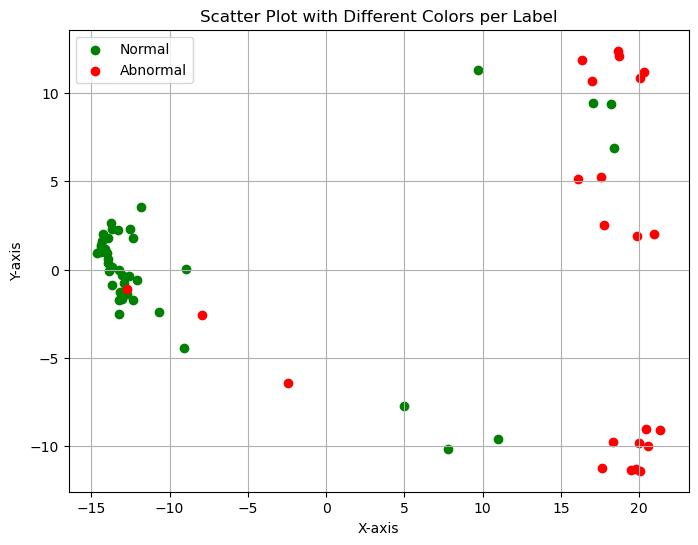

In [17]:
#Plotting the data
import matplotlib.pyplot as plt

colors = {0 : "green",
          1 : "red",}

names = {0 : "Normal",
         1 : "Abnormal"}

plt.figure(figsize=(8, 6))

# Plot each label's data with a specific color
for label in np.unique(labels_np):
    data = reduced_embedding[np.argwhere(labels_np == label)].squeeze()
    print(f"Number of {colors[label]} points: {data.shape[0]}")
    plt.scatter(data[:, 0], data[:, 1], color=colors[label], label=names[label])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Different Colors per Label')
plt.legend() # Display the legend
plt.grid(True)
plt.show()

In [18]:
print(

SyntaxError: incomplete input (149104261.py, line 1)

In [ ]:

#Doing the same thing but aggregating across three batches. Sometimes this just doesn't work; feel free to skip it. I was just curious
import itertools

embeddings = None
labels_all = None

for i in range(3):
    print(f"Printing {i}th slice:")    
    images, labels = next(itertools.islice(dataloader, i, None))

    images = images.to(device)

    embedding = encoder(images)

    if embeddings is None:
        embeddings = embedding
    else:
        embeddings = torch.cat((embeddings, embedding), dim = 0)

    if labels_all is None:
        labels_all = labels
    else:
        labels_all = torch.cat((labels_all, labels), dim = 0)

print(embeddings.shape)

Printing 0th slice:


In [ ]:
pca_all = PCA(n_components=2)

reduced_embeddings = pca_all.fit_transform(embeddings.to("cpu").detach().numpy())

In [ ]:
labels_np_all = labels_all.detach().numpy()

In [ ]:
count_all = {}

for i in range(6):
    count_all[i] = reduced_embeddings[np.argwhere(labels_np_all == i)].shape[0]

count_all

{0: 34, 1: 31, 2: 34, 3: 31, 4: 36, 5: 26}

Number of red points: 34
Number of green points: 31
Number of blue points: 34
Number of orange points: 31
Number of yellow points: 36
Number of purple points: 26


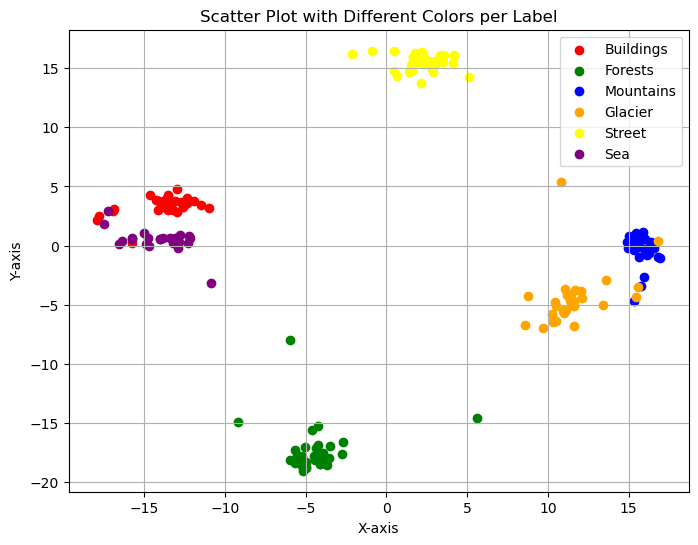

In [ ]:
plt.figure(figsize=(8, 6))

# Plot each label's data with a specific color
for label in np.unique(labels_np_all):
    data = reduced_embeddings[np.argwhere(labels_np_all == label)].squeeze()
    print(f"Number of {colors[label]} points: {data.shape[0]}")
    plt.scatter(data[:, 0], data[:, 1], color=colors[label], label=names[label])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Different Colors per Label')
plt.legend() # Display the legend
plt.grid(True)
plt.show()

In [ ]:
images_list = pd.read_csv("scene_data/train-scene classification/train.csv")

images_dir = "scene_data/train-scene classification/train/"

In [ ]:
image_path = images_list[images_list['label'] == 4].sample(1)['image_name'].iloc[0]

image = Image.open(images_dir + image_path).convert('RGB').resize((300,300))